Yijia Lu
1961366
5/15/2023

https://github.com/TClyj/EE-machine-learning-project.git

For the Lorenz equations (code given out previously in class emails), consider the following.

Train a NN to advance the solution from t to t + ∆t for ρ = 10, 28 and 40. Now see how well
your NN works for future state prediction for ρ = 17 and ρ = 35.

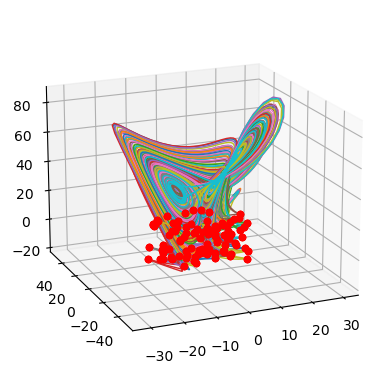

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

dt = 0.01
T = 8
t = np.arange(0, T+dt, dt)
beta = 8/3
sigma = 10
rho = [10, 28, 40]  # values of rho to use for training

# Initialize input and output arrays
nn_input = np.zeros((100 * len(rhos) * (len(t)-1), 3))
nn_output = np.zeros_like(nn_input)

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'})

# Lorenz system
def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(123)
x0 = -15 + 30 * np.random.random((100, 3))

# Generate trajectories for each value of rho
for i, rho in enumerate(rhos):
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t, args=(sigma, beta, rho)) for x0_j in x0])
    
    for j in range(100):
        start_idx = (i * 100 + j) * (len(t) - 1)
        end_idx = (i * 100 + j + 1) * (len(t) - 1)
        nn_input[start_idx:end_idx, :] = x_t[j, :-1, :]
        nn_output[start_idx:end_idx, :] = x_t[j, 1:, :]
        
        x, y, z = x_t[j,:,:].T
        ax.plot(x, y, z, linewidth=1)
        ax.scatter(x0[j,0], x0[j,1], x0[j,2], color='r')

ax.view_init(18, -113)
plt.show()

Epoch 1/10
6000/6000 [==============================] - 5s 723us/step - loss: 0.0550 - val_loss: 0.0040
Epoch 2/10
6000/6000 [==============================] - 4s 705us/step - loss: 8.5105e-04 - val_loss: 0.0023
Epoch 3/10
6000/6000 [==============================] - 4s 739us/step - loss: 6.4860e-04 - val_loss: 0.0024
Epoch 4/10
6000/6000 [==============================] - 4s 694us/step - loss: 6.1608e-04 - val_loss: 0.0017
Epoch 5/10
6000/6000 [==============================] - 4s 717us/step - loss: 5.8980e-04 - val_loss: 0.0017
Epoch 6/10
6000/6000 [==============================] - 4s 745us/step - loss: 5.5430e-04 - val_loss: 0.0016
Epoch 7/10
6000/6000 [==============================] - 4s 693us/step - loss: 5.4125e-04 - val_loss: 0.0015
Epoch 8/10
6000/6000 [==============================] - 4s 703us/step - loss: 5.3304e-04 - val_loss: 0.0015
Epoch 9/10
6000/6000 [==============================] - 4s 714us/step - loss: 5.2448e-04 - val_loss: 0.0015
Epoch 10/10
6000/6000 [=========

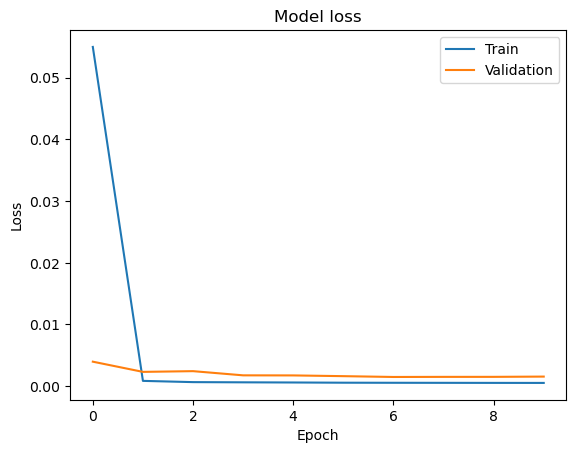

In [10]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# normalize the data
scaler = StandardScaler()
nn_input_scaled = scaler.fit_transform(nn_input)
nn_output_scaled = scaler.transform(nn_output)

# define the model
model = Sequential([
    Dense(10, input_shape=(3,), activation='relu'),
    Dense(3)
])

# compile the model
model.compile(optimizer='adam', loss='mse')

# train the model
history = model.fit(nn_input_scaled, nn_output_scaled, epochs=10, batch_size=32, validation_split=0.2)

# plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

5000/5000 [==============================] - 3s 492us/step
Mean squared error: 0.06433459881131638


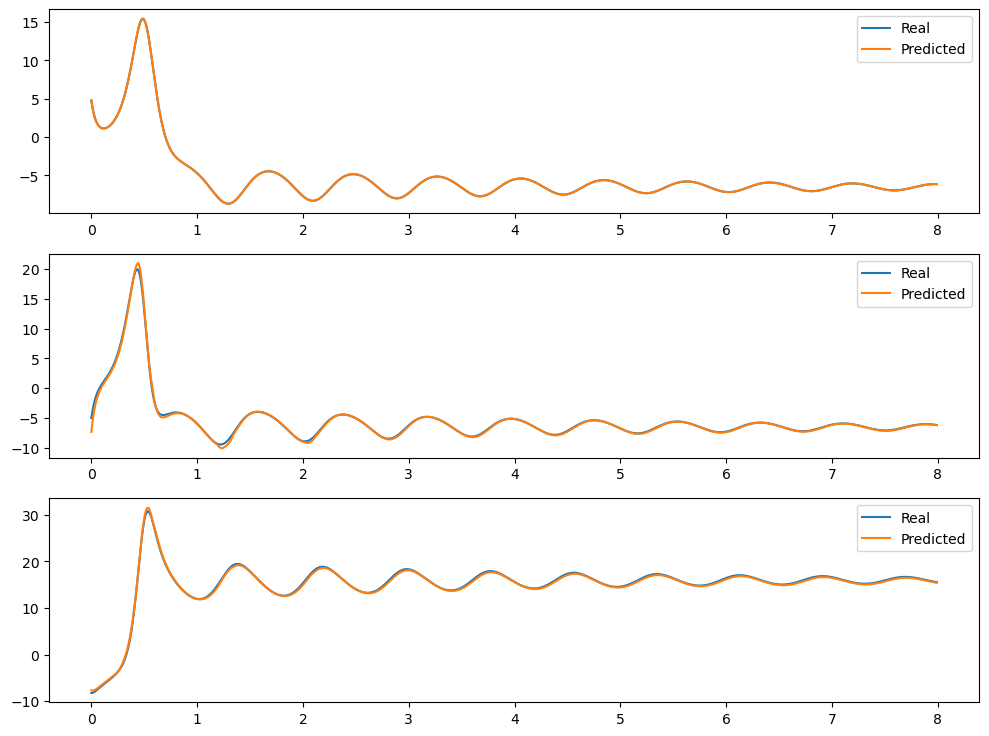

In [11]:
# Generate test data
rho_test_values = [17, 35]
nn_input_test = []
nn_output_test = []

for rho in rho_test_values:
    x_t_test = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t, args=(sigma, beta, rho)) for x0_j in x0])
    nn_input_test.append(x_t_test[:, :-1, :].reshape(-1, 3))
    nn_output_test.append(x_t_test[:, 1:, :].reshape(-1, 3))

nn_input_test = np.concatenate(nn_input_test)
nn_output_test = np.concatenate(nn_output_test)

# Normalize the test data
nn_input_test_scaled = scaler.transform(nn_input_test)
nn_output_test_scaled = scaler.transform(nn_output_test)

# Make predictions
nn_output_pred_scaled = model.predict(nn_input_test_scaled)
nn_output_pred = scaler.inverse_transform(nn_output_pred_scaled)

# Compute the error
error = nn_output_test - nn_output_pred
mse = np.mean(error**2)
print(f"Mean squared error: {mse}")

# Plot the real vs predicted values for the first test trajectory
plt.figure(figsize=(12, 9))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(t[:-1], nn_output_test[:len(t)-1, i], label='Real')
    plt.plot(t[:-1], nn_output_pred[:len(t)-1, i], label='Predicted')
    plt.legend()

plt.show()

Compare feed-forward, LSTM, RNN and Echo State Networks for forecasting the dynamics.

In [32]:
sequence_length = 10

In [33]:
import tensorflow as tf

# FFNN
model_ffnn = Sequential([
    Dense(10, input_shape=(3,), activation='relu'),
    Dense(3)
])

model_ffnn.compile(optimizer='adam', loss='mse')
history_ffnn = model_ffnn.fit(nn_input_scaled, nn_output_scaled, epochs=10, batch_size=32, validation_split=0.2)


# RNN
# Reshape the input for RNN
nn_input_rnn = nn_input_scaled.reshape((nn_input_scaled.shape[0], 1, nn_input_scaled.shape[1]))

# Define the RNN model architecture
model_rnn = tf.keras.Sequential()
model_rnn.add(tf.keras.layers.SimpleRNN(10, input_shape=(1, 3), activation='relu'))
model_rnn.add(tf.keras.layers.Dense(3))

# Compile the RNN model with Adam optimizer and mean squared error loss
model_rnn.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MSE)

# Train the RNN model on the normalized input and output data
history_rnn = model_rnn.fit(nn_input_rnn, nn_output_scaled, epochs=10, batch_size=32, validation_split=0.2)


# LSTM
# Reshape the input for LSTM
nn_input_lstm = nn_input_scaled.reshape((nn_input_scaled.shape[0], 1, nn_input_scaled.shape[1]))

# Define the LSTM model architecture
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(10, input_shape=(1, 3), activation='relu'))
model_lstm.add(tf.keras.layers.Dense(3))

# Compile the LSTM model with Adam optimizer and mean squared error loss
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MSE)

# Train the LSTM model on the normalized input and output data
history_lstm = model_lstm.fit(nn_input_lstm, nn_output_scaled, epochs=10, batch_size=32, validation_split=0.2)



Epoch 1/10
6000/6000 [==============================] - 5s 733us/step - loss: 0.0285 - val_loss: 0.0042
Epoch 2/10
6000/6000 [==============================] - 4s 713us/step - loss: 0.0011 - val_loss: 0.0031
Epoch 3/10
6000/6000 [==============================] - 5s 756us/step - loss: 8.2770e-04 - val_loss: 0.0024
Epoch 4/10
6000/6000 [==============================] - 4s 714us/step - loss: 6.9387e-04 - val_loss: 0.0021
Epoch 5/10
6000/6000 [==============================] - 4s 713us/step - loss: 6.5134e-04 - val_loss: 0.0020
Epoch 6/10
6000/6000 [==============================] - 4s 705us/step - loss: 6.3634e-04 - val_loss: 0.0020
Epoch 7/10
6000/6000 [==============================] - 5s 769us/step - loss: 6.2370e-04 - val_loss: 0.0021
Epoch 8/10
6000/6000 [==============================] - 4s 711us/step - loss: 6.1148e-04 - val_loss: 0.0019
Epoch 9/10
6000/6000 [==============================] - 4s 701us/step - loss: 5.9674e-04 - val_loss: 0.0022
Epoch 10/10
6000/6000 [=============

In [35]:

# FFNN
nn_output_pred_scaled_ffnn = model_ffnn.predict(nn_input_test_scaled)
nn_output_pred_ffnn = scaler.inverse_transform(nn_output_pred_scaled_ffnn)

error_ffnn = nn_output_test - nn_output_pred_ffnn
mse_ffnn = np.mean(error_ffnn**2)
print(f"FFNN mean squared error: {mse_ffnn}")


# RNN
# Reshape the input for RNN
nn_input_test_rnn = nn_input_test_scaled.reshape((nn_input_test_scaled.shape[0], 1, nn_input_test_scaled.shape[1]))

# Make predictions on the normalized test data using the trained RNN model
nn_output_pred_scaled_rnn = model_rnn.predict(nn_input_test_rnn)

# Rescale the predicted output back to the original scale using the scaler
nn_output_pred_rnn = scaler.inverse_transform(nn_output_pred_scaled_rnn)

# Compute the error between the predicted and actual test data
error_rnn = nn_output_test - nn_output_pred_rnn
mse_rnn = np.mean(error_rnn**2)

# Print the mean squared error
print(f"Mean squared error (RNN): {mse_rnn}")


# LSTM
# Reshape the input for LSTM
nn_input_test_lstm = nn_input_test_scaled.reshape((nn_input_test_scaled.shape[0], 1, nn_input_test_scaled.shape[1]))

# Make predictions on the normalized test data using the trained LSTM model
nn_output_pred_scaled_lstm = model_lstm.predict(nn_input_test_lstm)

# Rescale the predicted output back to the original scale using the scaler
nn_output_pred_lstm = scaler.inverse_transform(nn_output_pred_scaled_lstm)

# Compute the error between the predicted and actual test data
error_lstm = nn_output_test - nn_output_pred_lstm
mse_lstm = np.mean(error_lstm**2)

# Print the mean squared error
print(f"Mean squared error (LSTM): {mse_lstm}")

5000/5000 [==============================] - 3s 497us/step
FFNN mean squared error: 0.07112445069192463
5000/5000 [==============================] - 3s 522us/step
Mean squared error (RNN): 0.051269123672876164
5000/5000 [==============================] - 3s 556us/step
Mean squared error (LSTM): 0.01812997920166054


The source of my ESN class : https://github.com/cknd/pyESN/blob/master/testing.py

In [15]:
import numpy as np


def correct_dimensions(s, targetlength):
    """checks the dimensionality of some numeric argument s, broadcasts it
       to the specified length if possible.

    Args:
        s: None, scalar or 1D array
        targetlength: expected length of s

    Returns:
        None if s is None, else numpy vector of length targetlength
    """
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x


class ESN():

    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 random_state=None, silent=True):
        """
        Args:
            n_inputs: nr of input dimensions
            n_outputs: nr of output dimensions
            n_reservoir: nr of reservoir neurons
            spectral_radius: spectral radius of the recurrent weight matrix
            sparsity: proportion of recurrent weights set to zero
            noise: noise added to each neuron (regularization)
            input_shift: scalar or vector of length n_inputs to add to each
                        input dimension before feeding it to the network.
            input_scaling: scalar or vector of length n_inputs to multiply
                        with each input dimension before feeding it to the netw.
            teacher_forcing: if True, feed the target back into output units
            teacher_scaling: factor applied to the target signal
            teacher_shift: additive term applied to the target signal
            out_activation: output activation function (applied to the readout)
            inverse_out_activation: inverse of the output activation function
            random_state: positive integer seed, np.rand.RandomState object,
                          or None to use numpy's builting RandomState.
            silent: supress messages
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

        self.teacher_forcing = teacher_forcing
        self.silent = silent
        self.initweights()

    def initweights(self):
        # initialize recurrent weights:
        # begin with a random matrix centered around zero:
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        # delete the fraction of connections given by (self.sparsity):
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        # compute the spectral radius of these weights:
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        # rescale them to reach the requested spectral radius:
        self.W = W * (self.spectral_radius / radius)

        # random input weights:
        self.W_in = self.random_state_.rand(
            self.n_reservoir, self.n_inputs) * 2 - 1
        # random feedback (teacher forcing) weights:
        self.W_feedb = self.random_state_.rand(
            self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        """performs one update step.

        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern)
                             + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern))
        return (np.tanh(preactivation)
                + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        """multiplies the teacher/target signal by the teacher_scaling argument,
        then adds the teacher_shift argument to it."""
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        """inverse operation of the _scale_teacher method."""
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, inspect=False):
        """
        Collect the network's reaction to training data, train readout weights.

        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states

        Returns:
            the network's output on the training data, using the trained weights
        """
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        # transform input and teacher signal:
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)

        if not self.silent:
            print("harvesting states...")
        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :],
                                        teachers_scaled[n - 1, :])

        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        if not self.silent:
            print("fitting...")
        # we'll disregard the first few states:
        transient = min(int(inputs.shape[1] / 10), 100)
        # include the raw inputs:
        extended_states = np.hstack((states, inputs_scaled))
        # Solve for W_out:
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]),
                            self.inverse_out_activation(teachers_scaled[transient:, :])).T

        # remember the last state for later:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]

        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        # apply learned weights to the collected states:
        pred_train = self._unscale_teacher(self.out_activation(
            np.dot(extended_states, self.W_out.T)))
        if not self.silent:
            print(np.sqrt(np.mean((pred_train - outputs)**2)))
        return pred_train

    def predict(self, inputs, continuation=True):
        """
        Apply the learned weights to the network's reactions to new input.

        Args:
            inputs: array of dimensions (N_test_samples x n_inputs)
            continuation: if True, start the network from the last training state

        Returns:
            Array of output activations
        """
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[
                n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out,
                                                           np.concatenate([states[n + 1, :], inputs[n + 1, :]])))

        return self._unscale_teacher(self.out_activation(outputs[1:]))

In [25]:
# Initialize the ESN
esn = ESN(n_inputs=3, 
          n_outputs=3, 
          n_reservoir=200, 
          spectral_radius=0.95, 
          sparsity=0.0, 
          noise=0.001)

# Train the ESN
pred_train = esn.fit(nn_input_scaled, nn_output_scaled)

# Test the ESN
pred_test = esn.predict(nn_input_test_scaled)

# Truncate nn_output_scaled to match the length of pred_train and pred_test
truncated_output_scaled = nn_output_scaled[-len(pred_train):]
truncated_output_test_scaled = nn_output_test_scaled[-len(pred_test):]

# Compute the Mean Squared Error (MSE)
mse_esn_train = np.mean((pred_train - truncated_output_scaled)**2)
mse_esn_test = np.mean((pred_test - truncated_output_test_scaled)**2)

print(f'Training MSE for ESN: {mse_esn_train}')
print(f'Testing MSE for ESN: {mse_esn_test}')

Training MSE for ESN: 0.00018159825193539498
Testing MSE for ESN: 0.3000042108745584


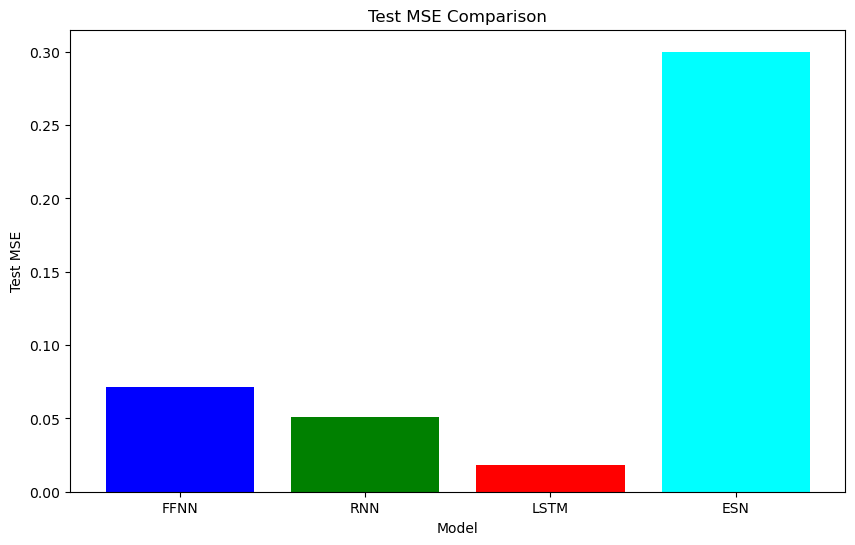

In [36]:
# Model names
models = ['FFNN', 'RNN', 'LSTM', 'ESN']

# Corresponding MSEs
mse_values = [mse_ffnn, mse_rnn, mse_lstm, mse_esn_test]

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, mse_values, color=['blue', 'green', 'red', 'cyan'])
plt.xlabel('Model')
plt.ylabel('Test MSE')
plt.title('Test MSE Comparison')
plt.show()